# Adv Data Mining

Colin Chu\
Wilshire Liu\
Zhuo Wen\
Yang Yuan

# Project 3: Topic Models
In this project, we will analyze the 20 newsgroup dataset (http://qwone.com/jason/20Newsgroups/) using topic models. We consider all the articles in the following two news groups: comp.sys.ibm.pc.hardware and comp.sys.mac.hardware.

Removing the stopwords from the vocabulary and further limiting the vocabulary to the top 1000 most frequent terms, we can now summarize the N_train training articles and N_test testing articles into a 1000×(N_train +N_test) word frequency count matrix. 

Denote this matrix as X.

In [20]:
# import sklearn
import warnings
warnings.filterwarnings('ignore')

from sklearn.datasets import fetch_20newsgroups
from pprint import pprint
hardware_train = fetch_20newsgroups(subset='train', categories =['comp.sys.ibm.pc.hardware','comp.sys.mac.hardware'])
hardware_test = fetch_20newsgroups(subset='test', categories =['comp.sys.ibm.pc.hardware','comp.sys.mac.hardware'])

#### Q1. Use tf as the feature for each document. Train a binary logistic regression model on the training set. Evaluate its document classification accuracy on the testing set.

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer

# get stopwords list
stopwords = open("stopwords.txt").read().replace('\n', ' ').split()

# vectorize and transform traning data using tf as the feature
tf_vectorizer = TfidfVectorizer(use_idf=False, 
                                max_features=1000, 
                                stop_words = stopwords)

tf_vectors = tf_vectorizer.fit_transform(hardware_train.data)

print("train vector shape:", tf_vectors.shape)

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# vectorize test data
tf_vectors_test = tf_vectorizer.transform(hardware_test.data)
print("test vector shape:", tf_vectors_test.shape)

# train
tf_clf = LogisticRegression(solver='lbfgs')
tf_clf.fit(tf_vectors, hardware_train.target)

# predict
tf_pred = tf_clf.predict(tf_vectors_test)
print("f1_score", f1_score(hardware_test.target,tf_pred,average='macro'))
print("accuracy:", accuracy_score(hardware_test.target, tf_pred))

train vector shape: (1168, 1000)
test vector shape: (777, 1000)
f1_score 0.8712826017811705
accuracy: 0.8712998712998713


#### Q2. Use tf-idf as the feature for each document and repeat Q1.

In [3]:
# vectorize and transform traning data using tf as the feature
tfidf_vectorizer = TfidfVectorizer(use_idf=True, 
                                max_features=1000, 
                                stop_words = stopwords)

tfidf_vectors = tfidf_vectorizer.fit_transform(hardware_train.data)

# vectorize test data
tfidf_vectors_test = tfidf_vectorizer.transform(hardware_test.data)

# train
tfidf_clf = LogisticRegression(solver='lbfgs')
tfidf_clf.fit(tfidf_vectors, hardware_train.target)

# predict
tfidf_pred = tfidf_clf.predict(tfidf_vectors_test)
print("f1_score", f1_score(hardware_test.target,tfidf_pred, average='macro'))
print("accuracy:", accuracy_score(hardware_test.target, tfidf_pred))

f1_score 0.8815799936386769
accuracy: 0.8815958815958816


#### Q3. Decompose X into USV T using SVD, where we set the dimension of U as 1000×20. Using SV T as the document features and repeat Q1.

In [4]:
#TODO: we don't have X yet
print(type(tf_vectors))
print(type(tf_vectors_test))
print(tf_vectors.shape)
print(tf_vectors_test.shape)

<class 'scipy.sparse.csr.csr_matrix'>
<class 'scipy.sparse.csr.csr_matrix'>
(1168, 1000)
(777, 1000)


### Using only tf

In [5]:
from scipy.sparse import coo_matrix, hstack, vstack
import numpy as np
tf_vectors_concat = vstack([tf_vectors,tf_vectors_test])
X = tf_vectors_concat.toarray().T
print(X.shape)

X_target = np.concatenate([hardware_train.target,hardware_test.target], axis=0)
print(X_target.shape)

(1000, 1945)
(1945,)


In [6]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(X, 
                              n_components=17,
                              n_iter=5,
                              random_state=1)
print(U.shape)
print(Sigma.shape)
print(VT.shape)

(1000, 17)
(17,)
(17, 1945)


In [7]:
# train
SVD_clf = LogisticRegression(solver='lbfgs')
SVD_clf.fit(Sigma*VT.T[:1168], hardware_train.target)

# predict
SVD_pred = SVD_clf.predict(Sigma*VT.T[1168:])
print("f1_score", f1_score(hardware_test.target,SVD_pred, average='macro'))
print("accuracy:", accuracy_score(hardware_test.target, SVD_pred))

f1_score 0.8441695990081697
accuracy: 0.8442728442728443


### Using tfidf

In [28]:
from scipy.sparse import coo_matrix, hstack, vstack
import numpy as np
tfidf_vectors_concat = vstack([tfidf_vectors,tfidf_vectors_test])
Xidf = tfidf_vectors_concat.toarray().T
print(Xidf.shape)

(1000, 1945)


In [29]:
from sklearn.utils.extmath import randomized_svd

U, Sigma, VT = randomized_svd(Xidf, 
                              n_components=17,
                              n_iter=5,
                              random_state=None)
print(U.shape)
print(Sigma.shape)
print(VT.shape)

(1000, 17)
(17,)
(17, 1945)


In [10]:
# train
SVD_clf = LogisticRegression(solver='lbfgs')
SVD_clf.fit(Sigma*VT.T[:1168], hardware_train.target)

# predict
SVD_pred = SVD_clf.predict(Sigma*VT.T[1168:])
print("f1_score", f1_score(hardware_test.target,SVD_pred, average='macro'))
print("accuracy:", accuracy_score(hardware_test.target, SVD_pred))

f1_score 0.8493959037753323
accuracy: 0.8494208494208494


In [11]:
svd_range = range(1,1001)
svd_accuracy = []
for num_topic in svd_range:
    U, Sigma, VT = randomized_svd(X, 
                                  n_components=num_topic,
                                  n_iter=5,
                                  random_state=1)

    SVD_clf = LogisticRegression(solver='lbfgs')
    SVD_clf.fit(Sigma*VT.T[:1168], hardware_train.target)

    # predict
    SVD_pred = SVD_clf.predict(Sigma*VT.T[1168:])
    svd_accuracy.append(accuracy_score(hardware_test.target, SVD_pred))
svd_loss = [1-x for x in svd_accuracy]

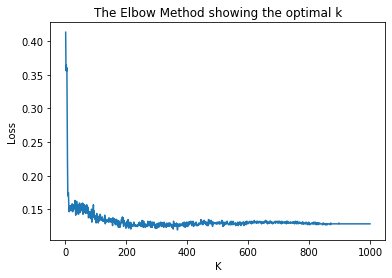

In [14]:
import matplotlib.pyplot as plt
plt.plot(svd_range, svd_loss)
plt.xlabel('K')
plt.ylabel('Loss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

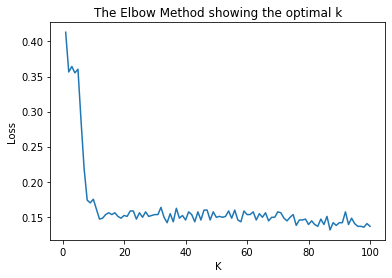

In [15]:
plt.plot(svd_range[:100], svd_loss[:100])
plt.xlabel('K')
plt.ylabel('Loss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### The elbow point is k=16 based on the graph.

#### Q4. Decompose X into WH with nonnegative matrix factorization (NMF), where we set the dimension of W as 1000 x 20. Using H as the document features and repeat Q1.

### Using tf

In [104]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=16, init='random', random_state=0)
W = nmf.fit_transform(X)
H = nmf.components_
print(W.shape)
print(H.shape)

(1000, 16)
(16, 1945)


In [105]:
# train
NMF_clf = LogisticRegression(solver='lbfgs')
NMF_clf.fit(H.T[:1168], hardware_train.target)

# predict
NMF_pred = NMF_clf.predict(H.T[1168:])
print("f1_score", f1_score(hardware_test.target,NMF_pred, average='macro'))
print("accuracy:", accuracy_score(hardware_test.target, NMF_pred))

f1_score 0.7987714987714988
accuracy: 0.7992277992277992


### Using tfidf

In [106]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=16, init='random', random_state=0)
W = nmf.fit_transform(Xidf)
H = nmf.components_
print(W.shape)
print(H.shape)

(1000, 16)
(16, 1945)


In [107]:
# train
NMF_clf = LogisticRegression(solver='lbfgs')
NMF_clf.fit(H.T[:1168], hardware_train.target)

# predict
NMF_pred = NMF_clf.predict(H.T[1168:])
print("f1_score", f1_score(hardware_test.target,NMF_pred, average='macro'))
print("accuracy:", accuracy_score(hardware_test.target, NMF_pred))

f1_score 0.8136690647482014
accuracy: 0.8146718146718147


In [54]:
nmf_range = range(1,100)
nmf_accuracy = []
for num_topic in nmf_range:
    nmf = NMF(n_components=num_topic, init='random', random_state=0)
    W = nmf.fit_transform(Xidf)
    H = nmf.components_
    NMF_clf = LogisticRegression(solver='lbfgs')
    NMF_clf.fit(H.T[:1168], hardware_train.target)
    NMF_pred = NMF_clf.predict(H.T[1168:])
    nmf_accuracy.append(accuracy_score(hardware_test.target, NMF_pred))
    
nmf_loss = [1-x for x in nmf_accuracy]

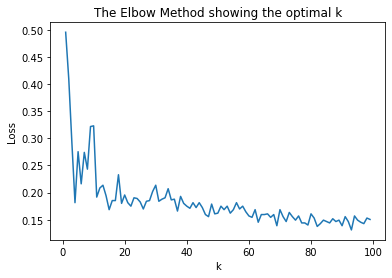

In [55]:
plt.plot(nmf_range, nmf_loss)
plt.xlabel('k')
plt.ylabel('Loss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### The elbow point is k=17 based on the graph.

#### Q5.   Apply latent Dirichlet allocation  (LDA)  to X to extract K=  20 topics Φ= (φ1, . . . ,φK) and a K-dimensional topic proportion  vector θj for each document. Using θj as the feature vector for document j and repeat Q1.

### Using tfidf

In [130]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=23, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
phi = lda.fit_transform(Xidf)
K = lda.components_
print(phi.shape)
print(K.shape)

(1000, 23)
(23, 1945)


In [131]:
# train
LDA_clf = LogisticRegression(solver='lbfgs')
LDA_clf.fit(K.T[:1168], hardware_train.target)

# predict
LDA_pred = LDA_clf.predict(K.T[1168:])
print("f1_score", f1_score(hardware_test.target, LDA_pred, average='macro'))
print("accuracy:", accuracy_score(hardware_test.target, LDA_pred))

f1_score 0.7390200319759239
accuracy: 0.7425997425997426


In [89]:
lda_range = range(1,100)
lda_accuracy = []
for num_topic in lda_range:
    lda = LatentDirichletAllocation(n_components=num_topic, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
    phi = lda.fit_transform(Xidf)
    K = lda.components_
    LDA_clf = LogisticRegression(solver='lbfgs')
    LDA_clf.fit(K.T[:1168], hardware_train.target)
    LDA_pred = LDA_clf.predict(K.T[1168:])
    lda_accuracy.append(accuracy_score(hardware_test.target, LDA_pred))
    
lda_loss = [1-x for x in lda_accuracy]

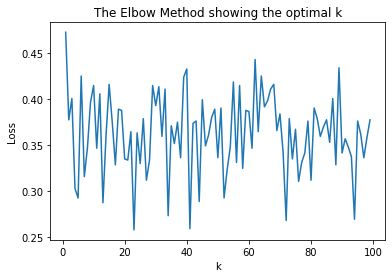

In [90]:
plt.plot(lda_range, lda_loss)
plt.xlabel('k')
plt.ylabel('Loss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

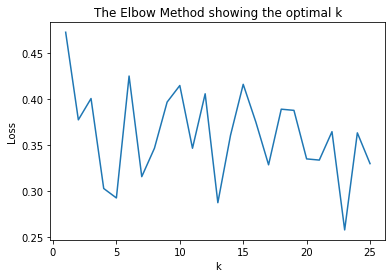

In [64]:
plt.plot(lda_range[:25], lda_loss[:25])
plt.xlabel('k')
plt.ylabel('Loss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### There is not an elbow point for LDA approach using tfidf.

### Using tf

In [21]:
from sklearn.feature_extraction.text import CountVectorizer

lda_tf_vectorizer = CountVectorizer(max_features=1000, stop_words=stopwords)
lda_tf = lda_tf_vectorizer.fit_transform(hardware_train.data)
lda_tf_test = lda_tf_vectorizer.transform(hardware_test.data)

lda_tf_vectors_concat = vstack([lda_tf, lda_tf_test])
lda_X = lda_tf_vectors_concat.toarray().T
print(lda_X.shape)

(1000, 1945)


In [36]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=12, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
phi = lda.fit_transform(lda_X)
K = lda.components_
print(phi.shape)
print(K.shape)

(1000, 12)
(12, 1945)


In [37]:
# train
LDA_clf = LogisticRegression(solver='lbfgs')
LDA_clf.fit(K.T[:1168], hardware_train.target)

# predict
LDA_pred = LDA_clf.predict(K.T[1168:])
print("f1_score", f1_score(hardware_test.target, LDA_pred, average='macro'))
print("accuracy:", accuracy_score(hardware_test.target, LDA_pred))

f1_score 0.7166114058355437
accuracy: 0.7168597168597168


In [24]:
lda_range = range(1,100)
lda_X_accuracy = []
for num_topic in lda_range:
    lda = LatentDirichletAllocation(n_components=num_topic, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
    phi = lda.fit_transform(lda_X)
    K = lda.components_
    LDA_clf = LogisticRegression(solver='lbfgs')
    LDA_clf.fit(K.T[:1168], hardware_train.target)
    LDA_pred = LDA_clf.predict(K.T[1168:])
    lda_X_accuracy.append(accuracy_score(hardware_test.target, LDA_pred))
    
lda_X_loss = [1-x for x in lda_X_accuracy]

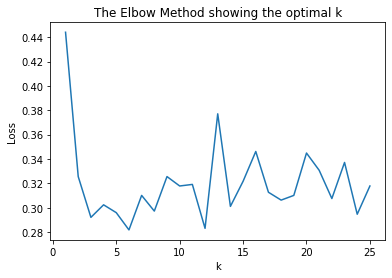

In [32]:
plt.plot(lda_range[:25], lda_X_loss[:25])
plt.xlabel('k')
plt.ylabel('Loss')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### The elbow point is k=12 based on the graph (using only tf).

#### Q6. Summarize your findings in terms of classification accuracy.

For SVD and NMF, using the entire word frequency matrix with the 1000 features produces a better accuracy than using the factorized matricies. Because we are using the method of “matrix factorization”, some of the information will not be captured, hence the classification accuracy will decrease compared to the first model with the entire 1000 features matrix. We think this is similar to how PCA works where reducing the amount of dimensions reduces the amount of variance and thus, less information can be used.

LDA prediction accuracy using tfidf is a bit higher than prediction accuracy using tf.

However, visualizing the topics of LDA works better with CountVectorizer and not tfidf. We tried to visualize the topics using tfidf, but many of the topics had the same group of words, but using only tf, we have a variety of words for each topic.

#### Q7.  Visualize the 20 topics (U in SVD, W in NMF, and Φ in LDA) by displaying the top 20 terms (ranked by their absolute values) in each topic.  Summarize your findings.

### SVD

In [140]:
import pandas as pd

keywords = np.array(tfidf_vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in U.T:
    top_keyword_locs = (-topic_weights).argsort()[:20]
    topic_keywords.append(keywords.take(top_keyword_locs))

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i+1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic'+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20
Topic1,edu,drive,com,scsi,lines,subject,organization,university,mac,card,posting,monitor,just,nntp,know,host,apple,article,thanks,problem
Topic2,scsi,drive,ide,controller,hard,drives,disk,bus,hd,isa,data,dma,devices,seagate,dos,transfer,pc,adaptec,oracle,floppy
Topic3,com,card,ibm,bus,austin,video,vlb,port,bit,isa,monitor,netcom,cards,cpu,ati,irq,local,board,pc,eisa
Topic4,scsi,edu,bus,ide,cwru,isa,vlb,bit,state,university,eisa,cleveland,washington,ohio,dma,quadra,faster,speed,mhz,simms
Topic5,mac,scsi,apple,lc,se,quadra,duo,dartmouth,ii,bmug,hades,org,nubus,ac,modem,centris,monitor,powerbook,know,fpu
Topic6,monitor,monitors,drive,video,vga,apple,17,power,nanao,screen,nec,card,hard,24,sony,drives,mit,problem,colors,color
Topic7,com,ibm,scsi,austin,cleveland,monitors,modem,cwru,ohio,monitor,power,freenet,day,just,ins,reserve,mac,nanao,copy,case
Topic8,cpu,uk,austin,clock,ibm,ac,mhz,washington,power,speed,fan,guy,apple,chip,centris,dartmouth,simms,drive,motherboard,040
Topic9,uk,ac,edu,cs,university,ibm,austin,cc,au,utexas,dept,state,monitor,thanks,help,keyboard,science,power,tel,duo
Topic10,uk,ac,cleveland,cpu,monitor,freenet,cwru,help,ohio,western,reserve,just,problem,bmug,modem,fan,ins,case,lc,card


We try to extract meanings out of some of the topics:

Topic 2: Data storage\
Topic 6: Computer peripherals\
Topic 17: Computer parts

### NMF

In [128]:
import pandas as pd

keywords = np.array(tfidf_vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in W.T:
    top_keyword_locs = (-topic_weights).argsort()[:20]
    topic_keywords.append(keywords.take(top_keyword_locs))

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i+1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic'+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20
Topic1,edu,university,nntp,host,posting,state,cc,subject,organization,lines,thanks,article,cs,utexas,news,distribution,cmu,upenn,new,andrew
Topic2,cpu,fan,au,power,oz,chip,running,australia,doing,gov,supply,case,just,vs,tape,michael,goes,use,pc,engineering
Topic3,simms,centris,610,simm,vram,ram,memory,meg,pin,uiuc,problems,machine,72,scott,800,quadra,650,just,iivx,problem
Topic4,scsi,ide,devices,nmsu,bit,mac,device,pc,dante,data,quadra,controller,drives,faster,vs,chip,interface,dos,drivers,asynchronous
Topic5,apple,dartmouth,lc,hades,duo,price,nubus,fpu,edu,iii,cd,new,mouse,pds,know,writes,don,brian,c650,lciii
Topic6,com,ibm,austin,netcom,hp,gateway,lance,writes,article,portal,reply,subject,lines,organization,guy,access,sgi,john,company,mike
Topic7,cleveland,cwru,freenet,western,reserve,ohio,ins,case,edu,just,po,usa,crash,copy,ms,love,windows,floppy,installed,called
Topic8,card,video,cards,drivers,diamond,ethernet,pds,windows,ati,bit,cache,nubus,fi,slot,lc,graphics,board,s3,irq,iisi
Topic9,modem,port,serial,irq,ports,mouse,modems,printer,help,pc,problem,software,use,dos,connect,interrupt,fax,internal,work,pin
Topic10,uk,ac,mark,nz,tel,university,help,ed,program,44,pc,new,st,cs,mail,info,peter,keyboard,dept,fax


We try to extract meanings out of some of the topics:

Topic 1: University education\
Topic 3: Memory\
Topic 8: GPU\
Topic 9: Network\
Topic 11: Monitors\
Topic 12: Data Storage

### LDA

In [38]:
import pandas as pd

keywords = np.array(lda_tf_vectorizer.get_feature_names())
topic_keywords = []
for topic_weights in phi.T:
    top_keyword_locs = (-topic_weights).argsort()[:20]
    topic_keywords.append(keywords.take(top_keyword_locs))

df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i+1) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic'+str(i+1) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15,Word 16,Word 17,Word 18,Word 19,Word 20
Topic1,duo,andrew,cmu,nz,battery,kevin,os2,public,pb,rit,audio,isc,pa,programmer,button,ed,ubc,du,nyx,ac
Topic2,bios,sys,tape,files,disks,error,adaptec,format,backup,oracle,seagate,errors,germany,config,formatting,aspi4dos,1542,exe,kit,eric
Topic3,dartmouth,040,hades,coprocessor,portal,c650,clark,college,650,math,fpu,brian,speak,care,dock,processor,drop,33mhz,pds,optional
Topic4,mouse,keyboard,adb,laserwriter,1280x1024,key,desktop,hand,interesting,cat,select,wires,checked,btw,command,years,open,option,switches,school
Topic5,simm,610,umich,colors,umcc,jon,ann,kth,mi,900,arbor,vram,games,nada,stereo,hz,mirsky,72,simms,sounds
Topic6,apr,gmt,v1,horizontal,vertical,___,useragent,nuntius,xxdate,tue,fi,mon,id,resolution,950,max,adapter,vga,93,23
Topic7,cleveland,fan,freenet,408,ins,po,reserve,bauer,mcmaster,ray,netcom,services,san,cwru,western,grayscale,00,informatik,crash,ms
Topic8,800,bmug,acs,cso,gary,illinois,urbana,ohio,uiuc,80ns,stephen,compare,state,il,org,bbs,motorola,tech,message,wait
Topic9,austin,cc,phone,computing,paul,bitnet,ucs,na,ford,sale,indiana,gordon,jeff,harris,al,mot,dan,shipping,srl,csd
Topic10,ati,486dx,dx2,brand,ultra,wright,gene,vesa,eisa,vlb,dk,66,harddisk,gateway,portable,conner,local,50,33mhz,build


We try to extract meanings out of some of the topics:

Topic 1: Programmers and their names\
Topic 2: Operating System\
Topic 4: Computer peripherals\
Topic 6: Monitors